In [32]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

DATA_DIR = Path("data/benchmarking/nogif_1000")
DATA_DIR = Path("data/benchmarking/nocars")
SEED = 2137
np.random.seed(SEED)

In [33]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [34]:
def get_n_sidewalk_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash_sidewalk"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [35]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_sidewalk_crashes": get_n_sidewalk_crashes(steps_df),
    }

    return steps_data

In [36]:
def get_scenarios_df(dir: Path):
    paths = list(dir.glob("*/*.json"))

    scenarios = []
    for file_path in tqdm(paths):

        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        dir = file_path.__str__().split("/")[-2]
        _, dr, _, dt = dir.split("_")
        scenario_data["decision_repeat"] = int(dr)
        scenario_data["dt"] = float(dt)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))
        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [37]:
df = get_scenarios_df(DATA_DIR)

100%|██████████| 10032/10032 [00:28<00:00, 351.50it/s]


In [38]:
df = df.set_index(
    [
        "dt",
        "decision_repeat",
        "seed",
    ],
    verify_integrity=True,
)

df = df.sort_index()

In [39]:
df

def.map_seq  \
dt   decision_repeat seed                                                      
0.02 5               0     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     1     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     2     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     3     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     4     [{'id': 'I', 'pre_block_socket_index': None}, ...   
...                                                                      ...   
0.04 20              831   [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     832   [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     833   [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     834   [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     835   [{'id': 'I', 'pre_block_socket_index': None}, ...   

                                                                 def.bv_data  \
dt   decision_repeat seed                                                      
0.02 5               0     [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     1     [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     2     [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     3     [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     4     [{'length': 4.515, 'width': 1.852, 'height': 1...   
...                                                                      ...   
0.04 20              831   [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     832   [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     833   [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     834   [{'length': 4.515, 'width': 1.852, 'height': 1...   
                     835   [{'length': 4.515, 'width': 1.852, 'height': 1...   

                           def.max_steps      start_ts  initialized_ts  \
dt   decision_repeat seed                                                
0.02 5               0              3364    295.398451      295.756016   
                     1              1892    305.808808      306.018085   
                     2              3574    312.702427      312.918462   
                     3              2092    321.409763      321.608535   
                     4              2815    329.054510      329.256271   
...                                  ...           ...             ...   
0.04 20              831             258  25031.559823    25031.973799   
                     832             268  25063.982803    25064.370704   
                     833             360  25098.926345    25099.265668   
                     834             239  25134.093840    25134.536072   
                     835             320  25167.107617    25167.405638   

                           scenario_done_ts  init_time  scenario_time  \
dt   decision_repeat seed                                               
0.02 5               0           296.732468   0.357566       0.976452   
                     1           306.512072   0.209277       0.493987   
                     2           313.648016   0.216035       0.729554   
                     3           322.189560   0.198772       0.581025   
                     4           329.887509   0.201761       0.631238   
...                                     ...        ...            ...   
0.04 20              831       25032.826719   0.413976       0.852919   
                     832       25064.633453   0.387901       0.262749   
                     833       25099.599978   0.339323       0.334310   
                     834       25134.839507   0.442232       0.303435   
                     835       25167.777781   0.298021       0.372143   

                           total_time  n_crashed_vehicles  \
dt   deci

In [40]:
# calculate driving score
# ! Problem changing the values here in the analysis can change % error
def calculate_driving_score(df):
    df["driving_score"] = (
        df["route_completion"]
        * df["in_road_percentage"]
        * (0.65) ** df["n_sidewalk_crashes"]
        * (0.60) ** df["n_crashed_vehicles"]
    )
    return df


df = calculate_driving_score(df)

In [41]:
df["driving_score"].describe()

count    10032.000000
mean         0.688012
std          0.387943
min          0.000180
25%          0.271996
50%          0.990132
75%          0.993000
max          1.003083
Name: driving_score, dtype: float64

# Getting featuers


## Getting scenario featuers


In [42]:
def get_features(col_name):
    x = df[col_name]
    x = x.reset_index(drop=True)
    x = pd.json_normalize(x)
    x = pd.concat(
        [pd.json_normalize(x[col]).add_prefix(f"{col}.") for col in x], axis=1
    )
    # convert lists to strings
    x = x.map(lambda x: ",".join(x) if isinstance(x, list) else x)
    x = pd.get_dummies(x)
    x = x.add_prefix(f"{col_name}.")
    return x

In [43]:
def_columns = ["def.map_seq", "def.bv_data"]


map_feat = get_features("def.map_seq")
bv_feat = get_features("def.bv_data")
S_df = map_feat.join(bv_feat)
S = S_df.to_numpy()

In [44]:
bv_feat

,def.bv_data.0.length,def.bv_data.0.width,def.bv_data.0.height,"def.bv_data.0.spawn_road_>,>>","def.bv_data.0.destination_4C0_1_,5S0_0_","def.bv_data.0.destination_4O0_3_,5S0_0_","def.bv_data.0.destination_4O1_3_,5S0_0_","def.bv_data.0.destination_4O2_3_,5S0_0_","def.bv_data.0.destination_4R0_1_,5S0_0_","def.bv_data.0.destination_4S0_0_,5S0_0_",...,"def.bv_data.0.destination_5O1_2_,5O1_3_","def.bv_data.0.destination_5O2_2_,5O2_3_","def.bv_data.0.destination_5R0_0_,5R0_1_","def.bv_data.0.destination_5T0_0_,5T0_1_","def.bv_data.0.destination_5T1_0_,5T1_1_","def.bv_data.0.destination_5T2_0_,5T2_1_","def.bv_data.0.destination_5X0_0_,5X0_1_","def.bv_data.0.destination_5X1_0_,5X1_1_","def.bv_data.0.destination_5X2_0_,5X2_1_","def.bv_data.0.destination_5r0_1_,5r0_2_"
0,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10027,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10028,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
10029,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
10030,4.515,1.852,1.19,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


## Get fid vector


In [45]:
fid = df.index.droplevel("seed")
fid = fid.to_numpy()

fid = np.vstack(fid)

fid.shape, fid,

((10032, 2),
 array([[ 0.02,  5.  ],
        [ 0.02,  5.  ],
        [ 0.02,  5.  ],
        ...,
        [ 0.04, 20.  ],
        [ 0.04, 20.  ],
        [ 0.04, 20.  ]]))

### Adding to scenario data


In [46]:
X = np.hstack((fid, S))
X.shape

(10032, 165)

## Get DScore vector


In [47]:
y = df["driving_score"].to_numpy()
y.shape, y

((10032,),
 array([0.99276847, 0.98963269, 0.99342371, ..., 0.64486575, 0.99333378,
        0.22846589]))

In [73]:
fid = df.index.droplevel("seed").to_series().reset_index()[["dt", "decision_repeat"]]
y_df = df["driving_score"].reset_index(drop=True)
S_df
data_df = pd.concat([y_df, fid, S_df], axis=1)

In [79]:
data_df.to_csv("data.csv", header=True, index=False)

weka_featuers = np.array(
    [
        2,
        3,
        6,
        15,
        24,
        34,
        36,
        42,
        50,
        52,
        59,
        60,
        61,
        64,
        65,
        69,
        71,
        76,
        78,
        80,
        84,
        89,
        92,
        97,
        98,
        105,
        118,
        122,
        125,
        132,
        143,
        147,
        155,
        157,
        158,
        163,
        165,
    ]
)

In [ ]:
weka_featuers

In [87]:
X = data_df.iloc[:, weka_featuers - 1].to_numpy()
y = data_df["driving_score"].to_numpy()

In [99]:
data_df["driving_score"].describe()

count    10032.000000
mean         0.688012
std          0.387943
min          0.000180
25%          0.271996
50%          0.990132
75%          0.993000
max          1.003083
Name: driving_score, dtype: float64

<Axes: >

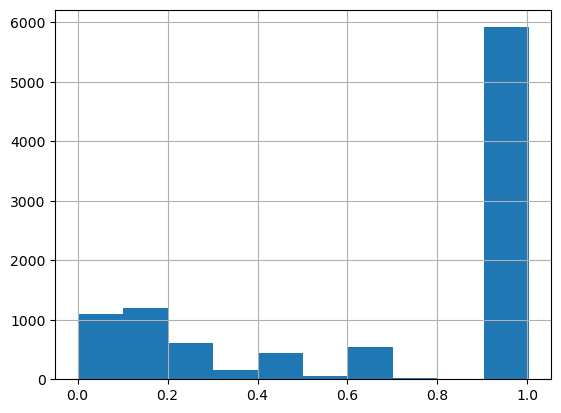

In [100]:
data_df["driving_score"].hist()

<Axes: >

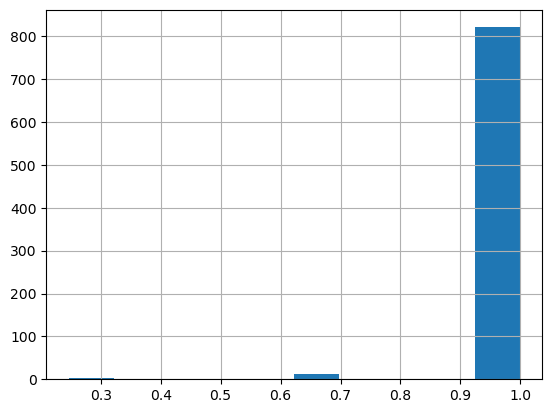

In [108]:
df.xs((0.02, 5))["driving_score"].hist()

# Fitting GPR


### Handling NaNs


In [88]:
X[pd.isna(X)] = -1
X.shape, y.shape

((10032, 37), (10032,))

In [89]:
X.shape[0] / 12

836.0

In [90]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, ShuffleSplit
from sklearn.metrics import r2_score

## Shuffle Splits


In [91]:
# splitter = LeaveOneOut()
# splitter.get_n_splits(X)

splitter = ShuffleSplit(test_size=100, n_splits=5, random_state=SEED)
splitter.get_n_splits(X)

5

In [92]:
data = []

for i, (train_index, test_index) in enumerate(splitter.split(X)):
    kernel = RBF(length_scale_bounds=(1e-5, 1e5))
    gaussian_process = GaussianProcessRegressor(
        kernel=kernel, n_restarts_optimizer=9, random_state=SEED
    )

    gaussian_process.fit(X[train_index], y[train_index])

    y_pred, y_std = gaussian_process.predict(X[test_index], return_std=True)
    y_true = y[test_index]
    # print(
    #     f"For index: \n{test_index} we predicted \n{y_pred} +- \n{y_std} but True value is: \n{y_true}"
    # )
    print(".")
    data.append([test_index, y_true, y_pred, y_std])

/home/olek/.miniconda3/envs/data-science/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


.
.


KeyboardInterrupt: 

In [93]:
r2_scores = []

for d in data:
    array = np.squeeze(d).T
    # print(array)
    results = pd.DataFrame(array, columns=["index", "y_true", "y_pred", "std"])
    results["y_pred"] = results["y_pred"].clip(0, 1)
    r2_scores.append(r2_score(results["y_true"], results["y_pred"]))


r2_scores = np.array(r2_scores)
print(f"r2_scores = {r2_scores}")
print(f"{r2_scores.mean() = :.2f}")

r2_scores = [-1.44933587 -0.68856546]
r2_scores.mean() = -1.07


In [94]:
results = pd.DataFrame(
    np.squeeze(data[0]).T, columns=["index", "y_true", "y_pred", "std"]
)
results["y_pred"] = results["y_pred"].clip(0, 1)
# results

In [95]:
r2_score(results["y_true"], results["y_pred"])

-1.4493358696011356

In [96]:
rmse = (results["y_true"] - results["y_pred"]).abs()
rmse.mean()

0.45125752191760266

In [97]:
results

,index,y_true,y_pred,std
0,5845.0,0.186688,0.413149,0.000005
1,3164.0,0.420579,0.412414,0.000007
2,4459.0,0.115225,0.007366,0.999906
3,4231.0,0.650564,0.010398,0.999906
4,6694.0,0.992170,0.009513,0.999953
...,...,...,...,...
95,9812.0,0.097007,0.002124,0.999953
96,5764.0,0.013426,0.010883,0.999906
97,7.0,0.988677,0.009507,0.999953
98,711.0,0.991170,0.991652,0.000010
